In [2]:
import numpy as np
from scipy.signal import cont2discrete
import casadi as ca
import matplotlib.pyplot as plt


In [4]:
# Define A and B FOR 
A = np.array([
    [0, 1, 0, 0],
    [0, -0.1818, 2.6742, 0],
    [0, 0, 0, 1],
    [0, -0.4545, 31.2121, 0]
])
B = np.array([
    [0],
    [1.8182],
    [0],
    [4.5455]
])

# Sampling time
Ts = 0.1

# Use scipy to discretize
system = (A, B, np.eye(4), np.zeros((4, 1)))
Ad, Bd, _, _, _ = cont2discrete(system, Ts)

print("Ad =\n", Ad)
print("Bd =\n", Bd)


Ad =
 [[ 1.00000000e+00  9.90914033e-02  1.36402147e-02  4.50663488e-04]
 [ 0.00000000e+00  9.81780356e-01  2.79056385e-01  1.36402147e-02]
 [ 0.00000000e+00 -2.31825502e-03  1.15995409e+00  1.05278654e-01]
 [ 0.00000000e+00 -4.74276893e-02  3.27976839e+00  1.15995409e+00]]
Bd =
 [[0.00908697]
 [0.18221648]
 [0.0231851 ]
 [0.47432907]]


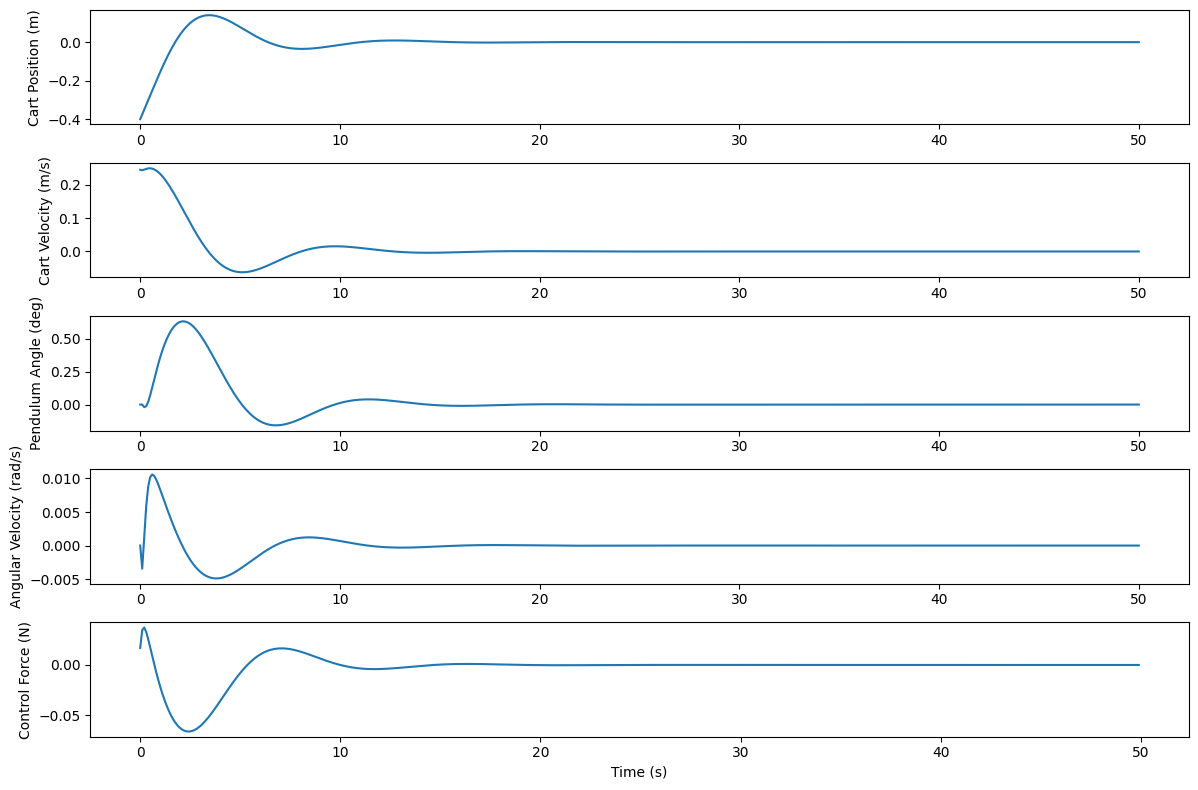

In [14]:
# I am doing two intial conditions for the 14pi/180

# Approximated values for Ad and Bd 
#------------------------------------

# Define discrete-time state-space matrices (from earlier derivation with Ts = 0.1)
Ad = np.array([
    [1.0, 0.1, 0.0, 0.0],
    [0.0, 0.9819, 0.2673, 0.0],
    [0.0, 0.0, 1.0, 0.1],
    [0.0, -0.0455, 3.1216, 1.0]
])
Bd = np.array([[0.0], [0.1818], [0.0], [0.4545]])

# Simulation parameters
Ts = 0.1
#-------- MY NOTE --------------------------------
#using smaller horizon will get un feasible solutions due to the fact of the constrained force along with the intial states
#------------------------
N = 10  # Prediction horizon 
T_sim = 50  # total simulation time in seconds
steps = int(T_sim / Ts)

# Cost matrices
Q = np.diag([10, 1, 100, 1])
R = np.diag([1])

# Constraints
theta_max = 15 * np.pi / 180
u_max = 2
du_max = 0.1

# Initial condition
# THE 14pi/180 to be the intial velocity 
x0 = np.array([-0.4, (14 * np.pi) / 180, 0, 0])



# Storage for simulation
x_hist = [x0]
u_hist = []

# CasADi optimization
nx = Ad.shape[0]
nu = Bd.shape[1]

opti = ca.Opti()
X = opti.variable(nx, N + 1)
U = opti.variable(nu, N)

# Objective
obj = 0
for k in range(N):
    obj += ca.mtimes([(X[:, k] - 0).T, Q, (X[:, k] - 0)]) + ca.mtimes([U[:, k].T, R, U[:, k]])
opti.minimize(obj)

# Dynamics constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == Ad @ X[:, k] + Bd @ U[:, k])

# Constraints
for k in range(N):
    opti.subject_to(-theta_max <= X[2, k])
    opti.subject_to(X[2, k] <= theta_max)
    opti.subject_to(-u_max <= U[:, k])
    opti.subject_to(U[:, k] <= u_max)
    if k > 0:
        opti.subject_to(U[:, k] - U[:, k-1] <= du_max)
        opti.subject_to(U[:, k-1] - U[:, k] <= du_max)

# Set initial condition parameter
x_init = opti.parameter(nx)
opti.subject_to(X[:, 0] == x_init)

# Solver setup
opts = {"ipopt.print_level": 0, "print_time": 0}
opti.solver("ipopt", opts)

# Simulation loop
x = x0.copy()
for _ in range(steps):
    opti.set_value(x_init, x)
    
    sol = opti.solve()
    u_scalar = sol.value(U[:, 0])
    u = np.array([[u_scalar]])  # shape: (1,1)

    
    # Propagate dynamics
    x_next = Ad @ x.reshape(-1, 1) + Bd @ u
    x = x_next.flatten()  # flatten back to 1D
    
    # Append data
    x_hist.append(x.copy())
    u_hist.append(u.item())  # Safe scalar extraction

    # Warm-start next solve
    opti.set_initial(X, sol.value(X))
    opti.set_initial(U, sol.value(U))

# Convert results to arrays
x_hist = np.array(x_hist)
u_hist = np.array(u_hist)

# Plotting
time = np.linspace(0, T_sim, steps + 1)
plt.figure(figsize=(12, 8))

plt.subplot(5, 1, 1)
plt.plot(time, x_hist[:, 0])
plt.ylabel("Cart Position (m)")

plt.subplot(5, 1, 2)
plt.plot(time, x_hist[:, 1])
plt.ylabel("Cart Velocity (m/s)")

plt.subplot(5, 1, 3)
plt.plot(time, x_hist[:, 2] * 180 / np.pi)
plt.ylabel("Pendulum Angle (deg)")

plt.subplot(5, 1, 4)
plt.plot(time, x_hist[:, 3])
plt.ylabel("Angular Velocity (rad/s)")

plt.subplot(5, 1, 5)
plt.plot(time[:-1], u_hist)
plt.ylabel("Control Force (N)")
plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()

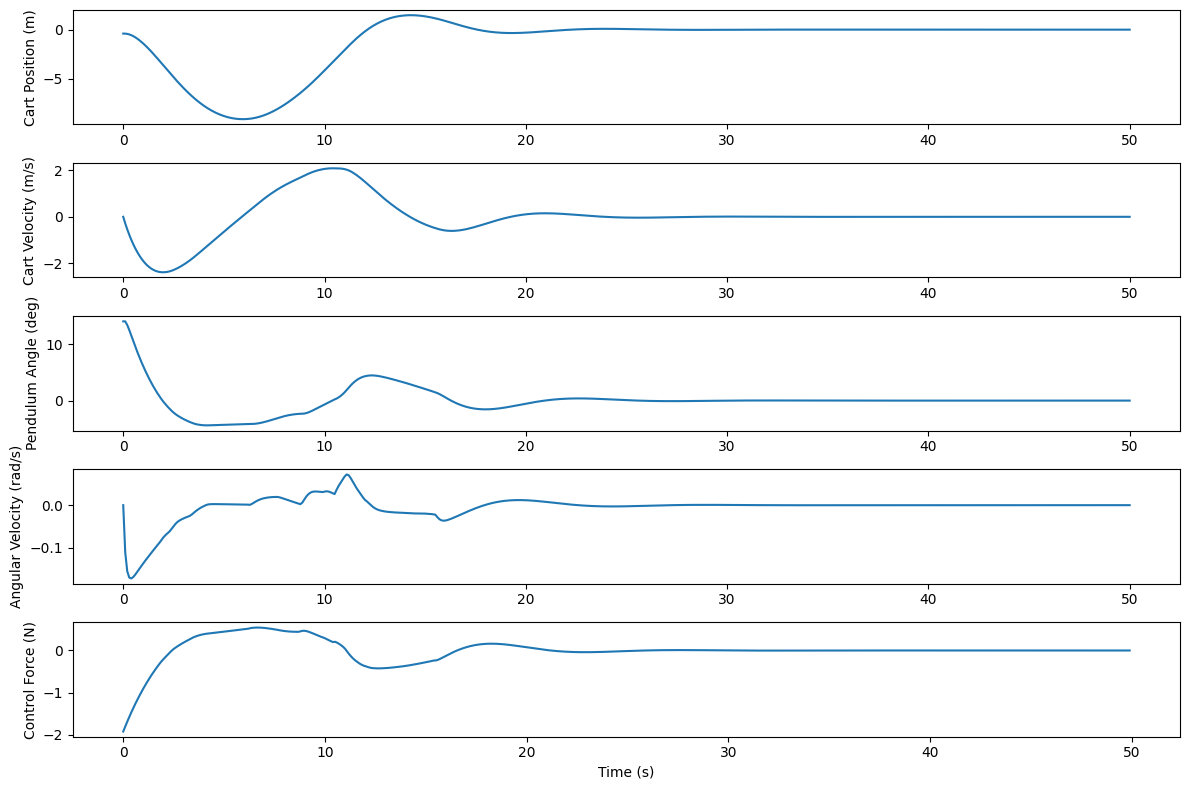

In [10]:
# Approximated values for Ad and Bd 
#------------------------------------

# Define discrete-time state-space matrices (from earlier derivation with Ts = 0.1)
Ad = np.array([
    [1.0, 0.1, 0.0, 0.0],
    [0.0, 0.9819, 0.2673, 0.0],
    [0.0, 0.0, 1.0, 0.1],
    [0.0, -0.0455, 3.1216, 1.0]
])
Bd = np.array([[0.0], [0.1818], [0.0], [0.4545]])

# Simulation parameters
Ts = 0.1
#-------- MY NOTE --------------------------------
#using smaller horizon will get un feasible solutions due to the fact of the constrained force along with the intial states
#------------------------
N = 10  # Prediction horizon 
T_sim = 50  # total simulation time in seconds
steps = int(T_sim / Ts)

# Cost matrices
Q = np.diag([10, 1, 100, 1])
R = np.diag([1])

# Constraints
theta_max = 15 * np.pi / 180
u_max = 2
du_max = 0.1

# THE 14pi/180 to be the intial angle  
# Initial condition
x0 = np.array([-0.4,0, (14 * np.pi) / 180, 0])

# Storage for simulation
x_hist = [x0]
u_hist = []

# CasADi optimization
nx = Ad.shape[0]
nu = Bd.shape[1]

opti = ca.Opti()
X = opti.variable(nx, N + 1)
U = opti.variable(nu, N)

# Objective
obj = 0
for k in range(N):
    obj += ca.mtimes([(X[:, k] - 0).T, Q, (X[:, k] - 0)]) + ca.mtimes([U[:, k].T, R, U[:, k]])
opti.minimize(obj)

# Dynamics constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == Ad @ X[:, k] + Bd @ U[:, k])

# Constraints
for k in range(N):
    opti.subject_to(-theta_max <= X[2, k])
    opti.subject_to(X[2, k] <= theta_max)
    opti.subject_to(-u_max <= U[:, k])
    opti.subject_to(U[:, k] <= u_max)
    if k > 0:
        opti.subject_to(U[:, k] - U[:, k-1] <= du_max)
        opti.subject_to(U[:, k-1] - U[:, k] <= du_max)

# Set initial condition parameter
x_init = opti.parameter(nx)
opti.subject_to(X[:, 0] == x_init)

# Solver setup
opts = {"ipopt.print_level": 0, "print_time": 0}
opti.solver("ipopt", opts)

# Simulation loop
x = x0.copy()
for _ in range(steps):
    opti.set_value(x_init, x)
    
    sol = opti.solve()
    u_scalar = sol.value(U[:, 0])
    u = np.array([[u_scalar]])  # shape: (1,1)

    
    # Propagate dynamics
    x_next = Ad @ x.reshape(-1, 1) + Bd @ u
    x = x_next.flatten()  # flatten back to 1D
    
    # Append data
    x_hist.append(x.copy())
    u_hist.append(u.item())  # Safe scalar extraction

    # Warm-start next solve
    opti.set_initial(X, sol.value(X))
    opti.set_initial(U, sol.value(U))

# Convert results to arrays
x_hist = np.array(x_hist)
u_hist = np.array(u_hist)

# Plotting
time = np.linspace(0, T_sim, steps + 1)
plt.figure(figsize=(12, 8))

plt.subplot(5, 1, 1)
plt.plot(time, x_hist[:, 0])
plt.ylabel("Cart Position (m)")

plt.subplot(5, 1, 2)
plt.plot(time, x_hist[:, 1])
plt.ylabel("Cart Velocity (m/s)")

plt.subplot(5, 1, 3)
plt.plot(time, x_hist[:, 2] * 180 / np.pi)
plt.ylabel("Pendulum Angle (deg)")

plt.subplot(5, 1, 4)
plt.plot(time, x_hist[:, 3])
plt.ylabel("Angular Velocity (rad/s)")

plt.subplot(5, 1, 5)
plt.plot(time[:-1], u_hist)
plt.ylabel("Control Force (N)")
plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()